# Reading from example SITL CSV and sourcing relevant data

The code does two things:

- Puts an SITL report into a basic DataFrame.
- Extracts an "event" (BBF) from the report, loads the MMS data and plots the relevant time frame.

In [1]:
# Just to get rid of IPython deprecation warnings:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# std lib imports
import datetime as dt
# 3rd party imports
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# local pkg imports
import pyspedas # as spds
import pytplot

The example SITL report was copied from recent reports with BBFs and/or DFs present.

In [2]:
# Read an example CSV file
sitl_df = pd.read_csv("../example/example_sitl_reports.csv", usecols=[0,1,2,3])

# Split the time column into start time and end time:
sitl_df[['STARTTIME','ENDTIME']] = sitl_df['START TIME          - END TIME'].str.split(" - ", expand=True)
# Parse the time columns into datetime objects:
tformat_sitl = '%Y-%m-%d/%H:%M:%S'
sitl_df['STARTTIME'] = pd.to_datetime(sitl_df['STARTTIME'], format=tformat_sitl)
sitl_df['ENDTIME'] = pd.to_datetime(sitl_df['ENDTIME'], format=tformat_sitl)
# Remove the original time format:
sitl_df = sitl_df.drop(columns='START TIME          - END TIME')

sitl_df.head()

,FOM,ID,DISCUSSION,STARTTIME,ENDTIME
0,100.0,tphan(EVA),weak BBF,2020-07-05 18:30:03,2020-07-05 18:31:23
1,100.0,tphan(EVA),weak BBF,2020-07-05 18:31:23,2020-07-05 18:32:43
2,120.0,tphan(EVA),tailward flows with negative Bz,2020-07-05 20:20:03,2020-07-05 20:22:33
3,120.0,tphan(EVA),tailward flows with negative Bz,2020-07-05 20:22:33,2020-07-05 20:25:03
4,120.0,tphan(EVA),tailward flows with negative Bz,2020-07-05 20:25:03,2020-07-05 20:27:23


In [3]:
# Take first line as example from CSV (it has a BBF):
test_event = sitl_df.loc[0]

# Extract dates of data we'll need for event:
trange = [test_event['STARTTIME'].strftime('%Y-%m-%d'), 
          (test_event['ENDTIME'] + dt.timedelta(days=1)).strftime('%Y-%m-%d')]
print("Using range of dates:", trange)

Using range of dates: ['2020-07-05', '2020-07-06']


In [4]:
# update local data dir if using no_update flag
pyspedas.mms.mms_config.CONFIG['local_data_dir'] = '../pydata'

# load B-field data from FGM (Fluxgate Magnetometer)
# use no_update=True to load local data
fgm_vars = pyspedas.mms.fgm(
    trange       =  trange,
    time_clip    =   False, # could truncate residuals at trange ends
    data_rate    =  'srvy', # survey frequency
    level        =    'l2', # ensure L2 products
    probe        =     '1', # could be ['1','2','3','4'] for all spacecraft
    #no_update    =    True, # load local data
)

25-Aug-20 20:56:58: Loading ../pydata/mms1/fgm/srvy/l2/2020/07/mms1_fgm_srvy_l2_20200705_v5.251.0.cdf


Loaded variables:
mms1_fgm_b_gse_srvy_l2
mms1_fgm_b_gsm_srvy_l2
mms1_fgm_b_dmpa_srvy_l2
mms1_fgm_b_bcs_srvy_l2
mms1_fgm_flag_srvy_l2
mms1_fgm_r_gse_srvy_l2
mms1_fgm_r_gsm_srvy_l2
mms1_fgm_hirange_srvy_l2
mms1_fgm_bdeltahalf_srvy_l2
mms1_fgm_stemp_srvy_l2
mms1_fgm_etemp_srvy_l2
mms1_fgm_mode_srvy_l2
mms1_fgm_rdeltahalf_srvy_l2


In [ ]:
alldata = pytplot.get_data('mms1_fgm_b_gsm_srvy_l2')

# Extract data:
t = alldata[0]
B_x = alldata[1][:,0]
B_y = alldata[1][:,1]
B_z = alldata[1][:,2]
Bt = alldata[1][:,3]

# convert to datetime axis
t_utc = np.array([dt.datetime.utcfromtimestamp(i) for i in t])

plt_tlims = (test_event['STARTTIME'] - dt.timedelta(minutes=15),
             test_event['ENDTIME'] + dt.timedelta(minutes=15))
inds = np.where(np.logical_and(t_utc > plt_tlims[0], t_utc < plt_tlims[1]))

It seems to have worked and has picked out the time of interesting signals!

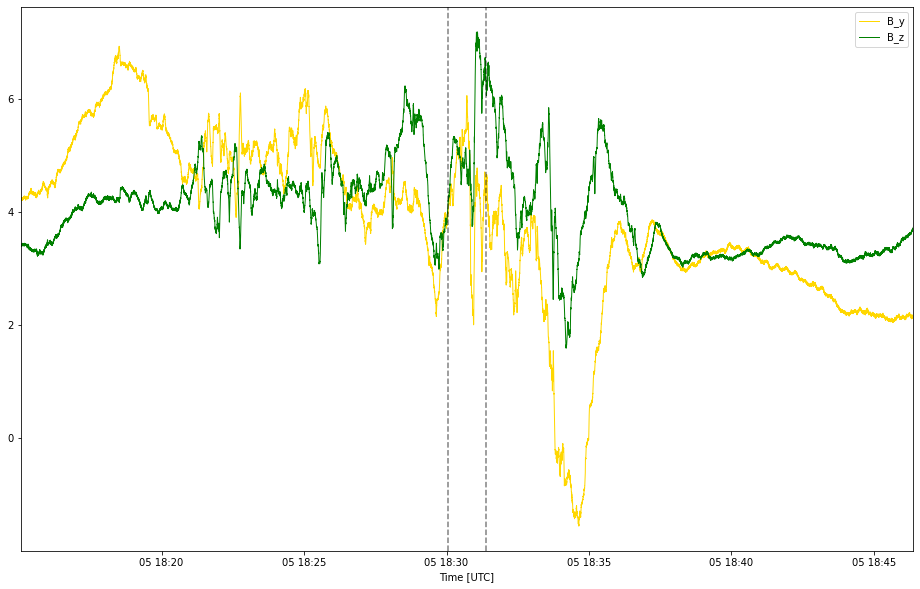

In [6]:
#----------------------------------------------------------------------
# plotting below
#----------------------------------------------------------------------

fig = plt.figure(figsize=(16,10))
plt.plot_date(t_utc[inds], B_y[inds], '-', lw=1, c='gold', label='B_y')
plt.plot_date(t_utc[inds], B_z[inds], '-', lw=1, c='green', label='B_z')
plt.axvline(test_event['STARTTIME'], ls='--', c='k', alpha=0.5)
plt.axvline(test_event['ENDTIME'], ls='--', c='k', alpha=0.5)
plt.xlim(plt_tlims)
plt.xlabel("Magnetic field [nT]")
plt.xlabel("Time [UTC]")
plt.legend()
plt.show()